In [34]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from Code.logistic_regression import log_loss_ridge, import_breast_cancer, accuracy_func, logistic_loss_func, logistic_grad, ridge_term, true_pos_variable_func, false_pos_variable_func
from Code.utilities import train_test_split, plot_test_results
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam, SGD, GD
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from Code.project1_tools import scale_feature_matrix

import jax.numpy as jnp
import numpy as np
from jax import nn, grad, jit, pmap


# Set the default font size for text elements (e.g., titles, labels)
sns.set() # default from sns is pretties (:
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
mpl.rcParams['font.family'] = 'sans-serif'


# Set filename start. Create the folder if gone
filepath_location = "Figures/e/"
if not os.path.exists(filepath_location):
    os.makedirs(filepath_location[0:-1])

In [8]:
X, y = import_breast_cancer()
X, means, var = scale_feature_matrix(X)

# Shuffle the data
permutation = np.random.permutation(X.shape[0])
X, y = X[permutation], y[permutation]

X = jnp.array(X)
y = jnp.array(y)
print(jnp.count_nonzero(y))
print(y.shape)

239
(683,)


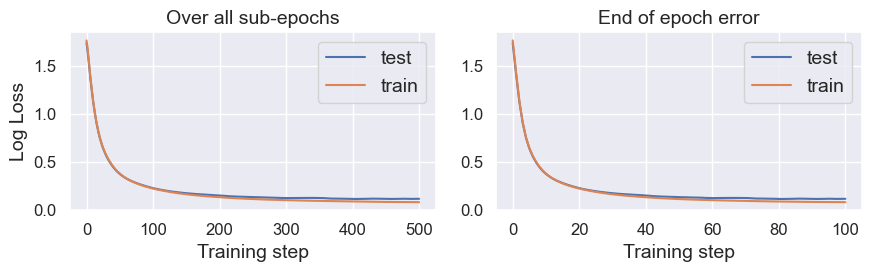

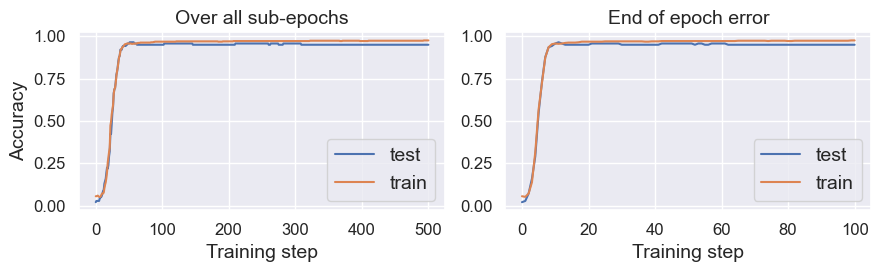

Log run


In [9]:
def single_run_logistic(X, y, lr, lam, test_index=None, plot_or_not=False):
    layer_list = [X.shape[1]] + [1]
    beta0 = _beta_init(layer_list)

    epochs = 100

    model = jit(get_neural_network_model(0 ,activation=None, output_activation=nn.sigmoid))

    loss_func = jit(logistic_loss_func(model=model))
    loss_grad = jit(grad(log_loss_ridge(model=model, lam=lam)))

    #print(loss_grad(beta0, X, y))


    acc_func = jit(accuracy_func(model))

    X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2, test_index=test_index)

    result = SGD_adam(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=[loss_func, acc_func], lr=lr)
    #result = SGD(X_train, y_train, X_test, y_test, grad_method=loss_grad,beta0=beta0, n_epochs=epochs, test_loss_func=test_func, lr=lr)

    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"][0], result["train_loss_list"][0], 5, ylabel="Log Loss")
        plot_test_results(result["test_loss_list"][1], result["train_loss_list"][1], 5, ylabel="Accuracy")


    return result





result = single_run_logistic(X, y, 8e-3, 0.000, plot_or_not=True)
print("Log run")
#result = single_run(X, y, 0.01, 0.001, 0, 5, hidden_activation=nn.relu)

In [10]:
activation_funcs = {"ReLu":nn.relu, "Leaky ReLu":nn.leaky_relu, "Sigmoid":nn.sigmoid, "Tanh":nn.tanh}
activation_func_cols = {"ReLu":"C0", "Leaky ReLu":"C1", "Sigmoid":"C2", "Tanh":"C3"}

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:34<00:00,  1.75it/s]


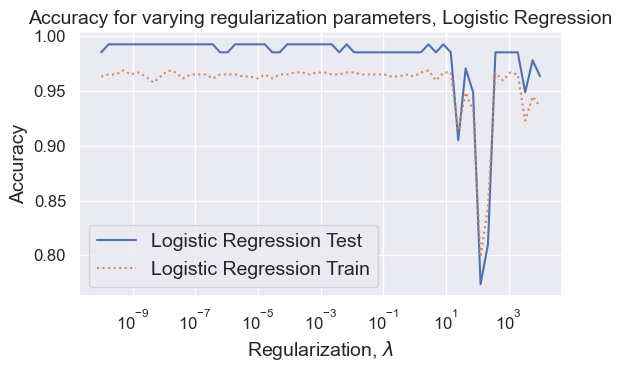

In [11]:
def search_lam(savefig=False):
    lr = 0.01
    
    
    filename = filepath_location + f"lr={lr}_lambda_experiment_logistic_regression.png"

    fig, ax = plt.subplots(figsize=(8, 5))

    lams = np.logspace(-10, 4, num=60)
    result = {}
    test_errs = []
    train_errs = []

    for lam in tqdm(lams):
        #tqdm.write(f"Lambda: {lam}")
        result = single_run_logistic(X, y, lr=lr, lam=lam, test_index=result.get("test_index"))
        test_errs.append(result["test_loss_list"][1][-1])
        train_errs.append(result["train_loss_list"][1][-1])


    plt.plot(lams, test_errs, label="Logistic Regression Test")
    plt.plot(lams, train_errs, linestyle="dotted", label="Logistic Regression Train")

    plt.legend()
    plt.title("Accuracy for varying regularization parameters, Logistic Regression")
    plt.ylabel("Accuracy")
    plt.xlabel(r"Regularization, $\lambda$")
    plt.xscale("log")
    plt.tight_layout()
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"lams":lams, "test_error":test_errs, "train_error":train_errs}

experiment = search_lam(savefig=True)

100%|██████████| 50/50 [02:26<00:00,  2.94s/it]


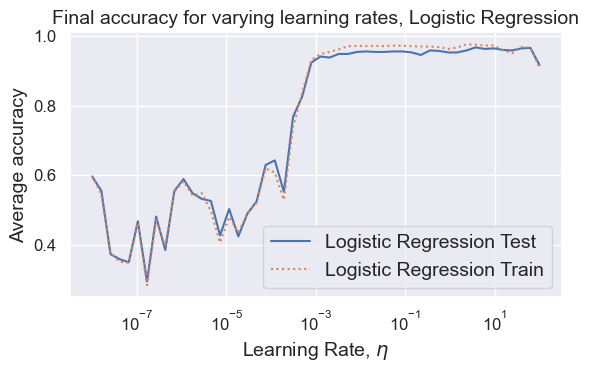

In [12]:

def search_lrs(savefig=False, nreps=5):
    lam = 1e-5

    
    
    filename = filepath_location + f"lambda={lam}_nreps={nreps}_lr_experiment_classification_logistic_regression.png"

    fig, ax = plt.subplots(figsize=(8, 5))

    lrs = np.logspace(-8, 2, num=50)


    acc_test_errs = []
    acc_train_errs = []
    result = {}
    for lr in tqdm(lrs):
        #tqdm.write(f"Learning rate: {lr}")
        s_test = 0.0
        s_train = 0.0
        for i in range(nreps):
            result = single_run_logistic(X, y, lr=lr, lam=lam, test_index=result.get("test_index"))
            s_test += result["test_loss_list"][1][-1]
            s_train += result["train_loss_list"][1][-1]
        acc_test_errs.append(s_test/nreps)
        acc_train_errs.append(s_train/nreps)

    plt.plot(lrs, acc_test_errs,  label="Logistic Regression Test")
    plt.plot(lrs, acc_train_errs,  linestyle="dotted", label="Logistic Regression Train")


    plt.legend()
    plt.title("Final accuracy for varying learning rates, Logistic Regression")
    plt.ylabel("Average accuracy")
    plt.xlabel(r"Learning Rate, $\eta$")
    plt.xscale("log")
    plt.tight_layout()
    if savefig:
        plt.savefig(filename)  
    plt.show()

    return {"lrs":lrs}


#learning_rate_exp = search_lrs()
l = search_lrs(savefig=True)

### Scikit learn

In [21]:
import sklearn

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Load the data
X, y = load_breast_cancer(return_X_y=True)

# Standardize the feature matrix
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Shuffle the data
permutation = np.random.permutation(X.shape[0])
X, y = X[permutation], y[permutation]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
lr = LogisticRegression(solver='lbfgs', max_iter=100, C=1e3)  # C=1e3 is equivalent to lambda=0.001
lr.fit(X_train, y_train)

# Predict and calculate accuracy
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9385964912280702


c:\Users\Trond\OneDrive\7. semester\FYS-STK3155 - Anvendt dataanalyse og maskinlæring\Projects\Project2_FYS_STK4155\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
# Inspired by https://compphysics.github.io/MachineLearning/doc/LectureNotes/_build/html/week38.html
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

data = load_breast_cancer()
X=data['data']
y=data['target']

# Get ready for average!
nreps = 10
tn_avg, fp_avg, fn_avg, tp_avg = 0,0,0,0

for i in range(nreps):

    X_train, y_train, X_test, y_test, test_index = train_test_split(X, y, 0.2)

    # Logistic Regression
    logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
    logreg.fit(X_train, y_train)

    # Make confusion matrix
    y_true = y_test
    y_pred = logreg.predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # print(tp, fn, sum(y_true))
    # print(fp, tn, sum(1-y_true))

    tp, fn = tp/sum(y_true), fn/sum(y_true)
    tn, fp = tn/sum((1-y_true)), fp/sum((1-y_true))

    tn_avg += tn/nreps 
    fn_avg += fn/nreps
    fp_avg += fp/nreps
    tp_avg += tp/nreps

    print(logreg.score(X_test,y_test))

confusion_matrix_values = [tp_avg, fn_avg, fp_avg, tn_avg]
print(confusion_matrix_values)

0.956140350877193
0.9473684210526315
0.9385964912280702
0.9649122807017544
0.9473684210526315
0.956140350877193
0.956140350877193
0.9473684210526315
0.9298245614035088
0.956140350877193
[0.9738437863771463, 0.026156213622853714, 0.09035765374586888, 0.9096423462541311]


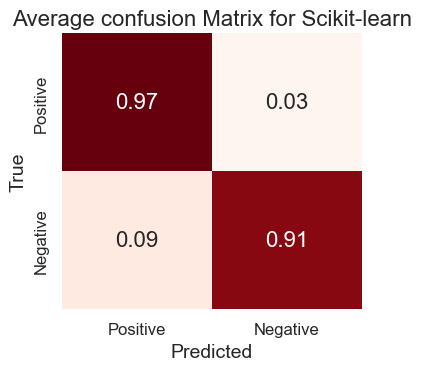

In [112]:
fig, ax = plt.subplots(1, figsize=(4, 4))
conf_matrix_array = np.array(confusion_matrix_values).reshape((2, 2))
sns.heatmap(conf_matrix_array, annot=True, fmt='.2f', xticklabels=['Positive', 'Negative'],
            yticklabels=['Positive', 'Negative'], cmap="Reds", ax=ax, cbar=False)
ax.set_title(f'Average confusion Matrix for Scikit-learn', fontsize=16)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(filepath_location+"scikit")
plt.show()